In [1]:
import numpy as np
from PIL import Image, ImageFont, ImageDraw
# import cv2
import sys
import matplotlib.pyplot as plt
%matplotlib inline

# normalize the image matrix
def toUINT(data):
    data-=data.min()
    data = 255.0*data/data.max()
    return data.astype(np.uint8)

# Convert RGB image to grayscale
def rgb2gray(img):
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    gray = 0.2126*R + 0.7152*G + 0.0722*B
    return toUINT(gray)

def showPhoto(ph, size=(8,8)):
    plt.figure(figsize=size)
    plt.imshow(ph, cmap = 'gray', interpolation='none')
    plt.show()
    
# Otsu binarization 
def binarizer(img):
    ret3,th3 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return th3

# BUG: symbol "-" is not processed correctly in case of small font sizes
def getSymbols(font, height, symbols=np.array(["@", "/", "\\", "0", "*", "|", "."], dtype=np.str)):
    font = ImageFont.truetype(font, height)
    bitmaps = {}
    
    for i in range(len(symbols)):
        img = Image.new(mode="L", size=(3*height, height), color=255)
        draw = ImageDraw.Draw(img)
        draw.text((0, 0), 2*symbols[i], font=font)
        buf_S = np.array(img)
        n = ((buf_S == 255*np.ones((height,1))).sum(axis=0) == height).argmin() + 1
        while not np.array_equal(buf_S[:,:n], buf_S[:,n:2*n]):
            n += 1
        bitmaps[symbols[i]] = buf_S[:,:n]
        
    return bitmaps

def getImage(pic, mode="grayscale"):
    img = Image.open(pic)
    img = np.array(img)
    
    if mode == "grayscale":
        return rgb2gray(img)
    elif mode == "binary":
        return binarizer(img)
    
def showSymbols(font, height, symbols, image_size, size=(8,8)):
    font = ImageFont.truetype(font, height)
    img = Image.new(mode="L", size=(image_size[1], len(symbols)*height), color=255)
    draw = ImageDraw.Draw(img)
    
    for i in range(len(symbols)):
        draw.text((0, height*i), "".join(symbols[i]), font=font)
        
    plt.figure(figsize=size)
    plt.imshow(img, cmap="gray")
    plt.show()

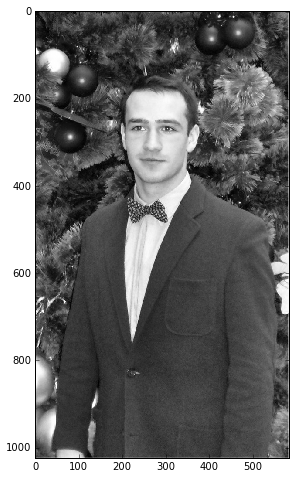

In [2]:
showPhoto(getImage("van9.jpg"))

In [3]:
symbol_height = 24

symbols = getSymbols("arial.ttf", symbol_height)
image = getImage("van9.jpg")

Cut the image to make its height to be divisible by symbols height. (**Useless in current implementation**)

In [4]:
rows_number = image.shape[0] / symbol_height
print image.shape
image = image[:rows_number*symbol_height, :]
print image.shape

(1024, 582)
(1008, 582)


In [65]:
cache = np.zeros((rows_number, image.shape[1]), int)
cache.fill(-1)
next_symbol = np.zeros((rows_number, image.shape[1] + 1), str)
next_symbol.fill('')
inf = sys.maxint

def loss1(row, pos, symbol):
    image_part = image[row * symbol_height : (row + 1) * symbol_height, pos : pos + symbol.shape[1]]
    symbol[symbol == 255] = 0
    pixels = symbol.nonzero()
    if image_part.shape != symbol.shape:
        return inf
    return np.linalg.norm(symbol[pixels[0],pixels[1]] - image_part[pixels[0],pixels[1]])**2

def loss(row, pos, symbol):
    image_part = image[row * symbol_height : (row + 1) * symbol_height, pos : pos + symbol.shape[1]]
    if image_part.shape != symbol.shape:
        return inf
    return np.linalg.norm(symbol - image_part)**2

def dp(row, pos):
    if pos == image.shape[1]:
        return 0
    
    if pos > image.shape[1]:
        return inf
    
    if cache[row, pos] != -1:
        return cache[row, pos]
    
    res = inf
    
    for symbol_key, symbol in symbols.iteritems():
        next_pos = pos + symbol.shape[1]
        cur_res = dp(row, next_pos) + loss(row, pos, symbol)
        if cur_res < res:
            res = cur_res
            next_symbol[row, pos] = symbol_key
    cache[row, pos] = res
    return res

taken_symbols = []

for row in xrange(rows_number):
    dp(row, 0)
    cur_symbols = []
    pos = 0 
    while pos != image.shape[1]:
        cur_symbols.append(next_symbol[row, pos])
        pos += symbols[next_symbol[row, pos]].shape[1]
    cur_symbols = cur_symbols[::-1]
    taken_symbols.append(cur_symbols)

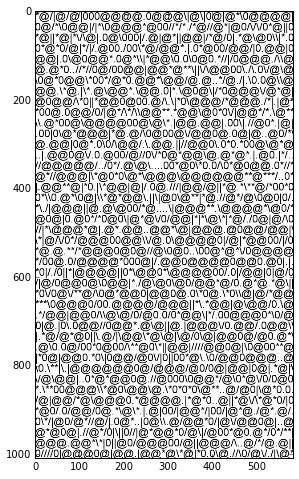

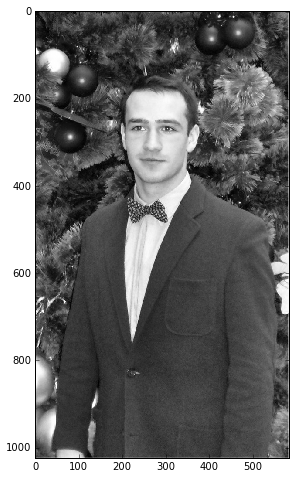

In [66]:
showSymbols("arial.ttf", symbol_height, taken_symbols, image.shape)
showPhoto(getImage("van9.jpg"))

In [67]:
print symbols['@'].shape[1]
print symbols['.'].shape[1]

24
7


In [68]:
for t in taken_symbols:
    print "---------------"
    print t
    length = np.sum([symbols[i].shape[1] for i in t])
    print length

---------------
['*', '@', '/', '|', '@', '/', '@', '|', '0', '0', '0', '@', '@', '@', '@', '.', '0', '@', '@', '@', '\\', '|', '@', '\\', '|', '0', '@', '|', '@', '*', '\\', '0', '@', '@', '@', '@', '|']
582
---------------
['0', '@', '/', '*', '\\', '0', '@', '@', '|', '/', '|', '*', '\\', '0', '@', '@', '@', '*', '@', '0', '0', '/', '/', '*', '/', '*', '.', '/', '*', '@', '/', '/', '@', '*', '|', '@', '0', '/', '\\', '/', '\\', '/', '0', '*', '@', '|', '|', '0']
582
---------------
['*', '@', '|', '|', '*', '@', '|', '*', '\\', '/', '\\', '@', '|', '.', '0', '@', '\\', '0', '0', '0', '|', '/', '.', '@', '|', '@', '*', '|', '|', '@', '@', '|', '/', '*', '@', '/', '0', '|', '.', '*', '@', '\\', '@', '0', '\\', '\\', '|', '*', '.', '0']
582
---------------
['0', '*', '@', '*', '0', '/', '@', '|', '*', '/', '|', '/', '.', '@', '0', '0', '.', '/', '0', '0', '\\', '*', '@', '/', '@', '@', '*', '.', '|', '.', '0', '*', '@', '0', '0', '/', '@', '@', '/', '|', '0', '.', '@', '@', '|', '0']
5